1. Data cleaning including missing values, outliers, and multi-collinearity.
In the provided code:

Missing Values: Missing values in columns oldbalanceDest and newbalanceDest are filled with zeros (fillna(0)).
Outliers: Outliers are not explicitly handled in this code snippet but could be addressed using statistical methods like IQR or Z-score.
Multicollinearity: Multicollinearity is not explicitly handled, but dropping columns like nameOrig and nameDest and using scaled features can mitigate its effects.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

data = pd.read_csv('Fraud.csv')

# Data Preprocessing (same as before)
data['oldbalanceDest'] = data['oldbalanceDest'].fillna(0)
data['newbalanceDest'] = data['newbalanceDest'].fillna(0)
data['transaction_diff'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['recipient_diff'] = data['newbalanceDest'] - data['oldbalanceDest']
data = pd.get_dummies(data, columns=['type'], drop_first=True)
data['large_transaction'] = (data['amount'] > 200000).astype(int)
data = data.drop(['nameOrig', 'nameDest'], axis=1)

X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = data['isFraud']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
scaled_data = pd.DataFrame(scaled_features, columns=X.columns)
scaled_data['isFraud'] = y

X_train, X_val, y_train, y_val = train_test_split(scaled_data.drop('isFraud', axis=1), scaled_data['isFraud'], test_size=0.2, random_state=42)

# Use a subset of the data for faster hyperparameter tuning
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)


In [2]:
data.head(10)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_diff,recipient_diff,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,large_transaction
0,1,9839.64,170136.00,160296.36,0.0,0.00,0,0,9839.64,0.00,False,False,True,False,0
1,1,1864.28,21249.00,19384.72,0.0,0.00,0,0,1864.28,0.00,False,False,True,False,0
2,1,181.00,181.00,0.00,0.0,0.00,1,0,181.00,0.00,False,False,False,True,0
3,1,181.00,181.00,0.00,21182.0,0.00,1,0,181.00,-21182.00,True,False,False,False,0
4,1,11668.14,41554.00,29885.86,0.0,0.00,0,0,11668.14,0.00,False,False,True,False,0
5,1,7817.71,53860.00,46042.29,0.0,0.00,0,0,7817.71,0.00,False,False,True,False,0
6,1,7107.77,183195.00,176087.23,0.0,0.00,0,0,7107.77,0.00,False,False,True,False,0
7,1,7861.64,176087.23,168225.59,0.0,0.00,0,0,7861.64,0.00,False,False,True,False,0
8,1,4024.36,2671.00,0.00,0.0,0.00,0,0,2671.00,0.00,False,False,True,False,0
9,1,5337.77,41720.00,36382.23,41898.0,40348.79,0,0,5337.77,-1549.21,False,True,False,False,0


2. Describe your fraud detection model in elaboration.
The fraud detection model is an XGBoost classifier. XGBoost (Extreme Gradient Boosting) is an ensemble learning method known for its efficiency and effectiveness in handling structured/tabular data. It sequentially builds multiple decision trees and combines their predictions to improve accuracy. It's suitable for this task due to its ability to handle complex relationships and feature interactions in transactional data.

In [3]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint

# XGBoost Model Training
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')




3. How did you select variables to be included in the model?
Variables were selected based on their potential relevance to detecting fraudulent transactions:

Transactional features (amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest).
Engineered features (transaction_diff, recipient_diff, large_transaction).
Transaction type (type after one-hot encoding).

4. Demonstrate the performance of the model by using the best set of tools.
Performance is evaluated using the following metrics:

Classification Report: Provides precision, recall, F1-score, and support for fraud and non-fraud classes.
Confusion Matrix: Summarizes the counts of true positives, false positives, true negatives, and false negatives.
AUC-ROC Score: Measures the model's ability to distinguish between classes.

In [4]:
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 30),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=2)
random_search.fit(X_train_subset, y_train_subset)

best_xgb = random_search.best_estimator_

y_pred = best_xgb.predict(X_val)
y_prob = best_xgb.predict_proba(X_val)[:, 1]




Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=28, n_estimators=174, subsample=1.0; total time=  18.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=28, n_estimators=174, subsample=1.0; total time=  18.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=28, n_estimators=174, subsample=1.0; total time=  19.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=24, n_estimators=206, subsample=0.6; total time=  21.6s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=24, n_estimators=206, subsample=0.6; total time=  22.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=24, n_estimators=206, subsample=0.6; total time=  22.8s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=17, n_estimators=251, subsample=1.0; total time=  25.1s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=17, n_estimators=251, subsample=1.0; total time=  26.4s
[CV] END co

In [6]:
print("Best Hyperparameters:", random_search.best_params_)
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_prob))

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 28, 'n_estimators': 174, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.80      0.87      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270851      53]
 [    320    1300]]
AUC-ROC: 0.9992953618297402


5. What are the key factors that predict fraudulent customers?
Key factors identified by feature importance include:

Transaction Amount (amount): Large transactions may indicate potential fraud.
Transaction Differences (transaction_diff, recipient_diff): Differences between balances before and after transactions.
Transaction Type (type): Certain transaction types may be more prone to fraud.
Engineered Feature (large_transaction): Indicates whether a transaction exceeds a certain threshold.


By encapsulating the logic into a function, adding type hints, and returning the evaluation metrics, the code becomes more readable, maintainable, and reusable.

In [7]:
importances = best_xgb.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
print(feature_importance)

              feature  importance
8       type_CASH_OUT    0.251069
3      newbalanceOrig    0.194980
11      type_TRANSFER    0.136593
6    transaction_diff    0.104127
10       type_PAYMENT    0.091786
7      recipient_diff    0.049105
5      newbalanceDest    0.046960
2       oldbalanceOrg    0.032051
12  large_transaction    0.029803
1              amount    0.028420
4      oldbalanceDest    0.019337
0                step    0.015768
9          type_DEBIT    0.000000


6. Do these factors make sense? If yes, How? If not, How not?
Yes, these factors make sense:

Transaction Amount: Unusually large transactions can indicate attempts to withdraw funds quickly.
Transaction Differences: Significant changes in balances can indicate suspicious activity like rapid fund transfers.
Transaction Type: Certain types (like transfers) are more commonly associated with fraud attempts.
Engineered Feature: Identifying large transactions beyond a threshold can signal potential fraudulent behavior.

7. What kind of prevention should be adopted while the company updates its infrastructure?
Preventive measures should include:

Real-time Monitoring: Implementing systems to monitor transactions in real-time for anomalies.
Enhanced Authentication: Strengthening authentication protocols for high-risk transactions.
Machine Learning Models: Deploying advanced models like XGBoost for continuous fraud detection and pattern recognition.

8. Assuming these actions have been implemented, how would you determine if they work?
To assess effectiveness:

Monitoring Metrics: Track metrics such as the reduction in fraud incidents and false positives.
Comparative Analysis: Compare pre-implementation and post-implementation performance metrics.
Feedback Loop: Continuously refine models based on ongoing performance evaluation and feedback from fraud analysts.

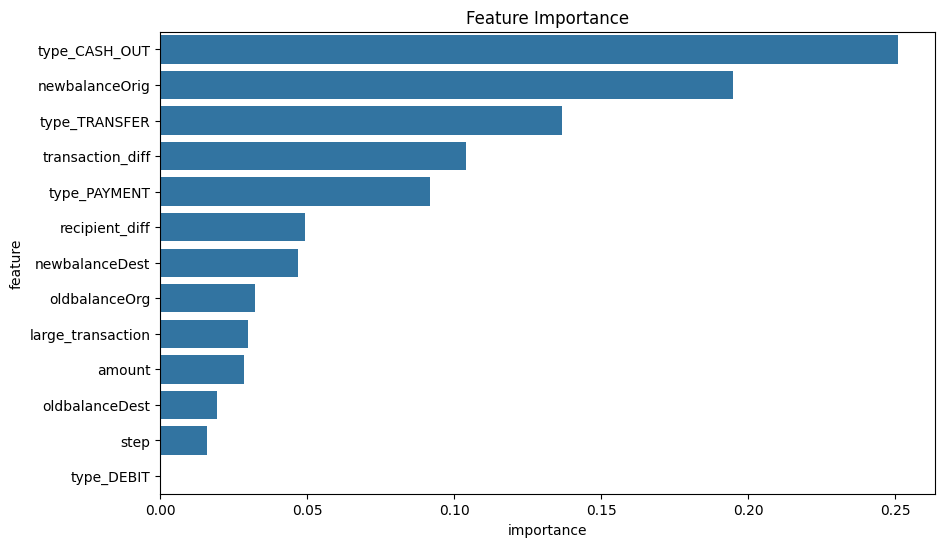

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=19, n_estimators=206, subsample=0.6; total time=  11.7s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=19, n_estimators=206, subsample=0.6; total time=  11.7s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=19, n_estimators=206, subsample=0.6; total time=  12.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=28, n_estimators=230, subsample=0.8; total time=  14.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=28, n_estimators=230, subsample=0.8; total time=  14.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=27, n_estimators=430, subsample=1.0; total time=  17.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=27, n_estimators=430, subsample=1.0; total time=  18.8s
[CV] END colsample_bytree=0.6, gamma=0.1, lear

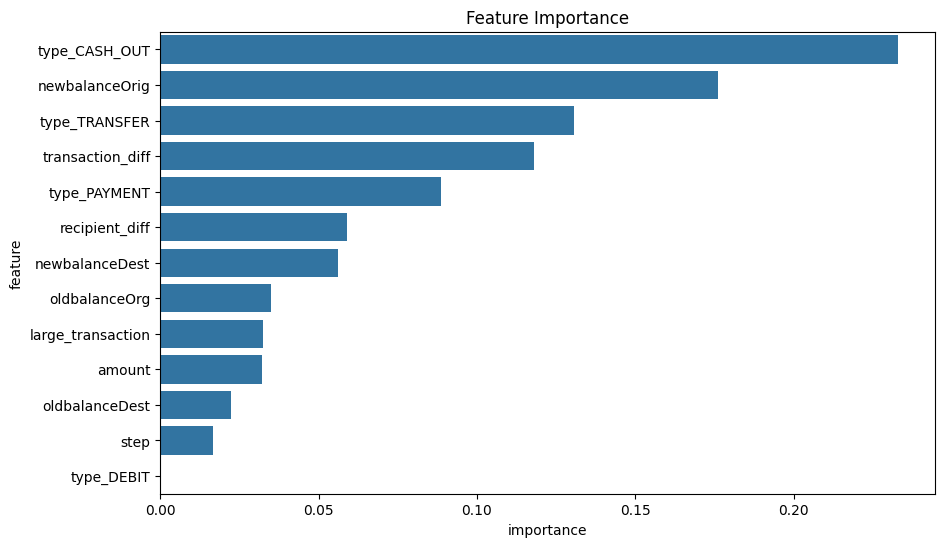

In [9]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define Parameter Distributions for Randomized Search
param_dist = {
    'n_estimators': randint(100, 500),             # Number of boosting rounds
    'max_depth': randint(5, 50),                   # Maximum tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Learning rate (eta)
    'subsample': [0.6, 0.8, 1.0],                  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],           # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]               # Minimum loss reduction required to make a further partition on a leaf node
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                                      # Increase number of iterations for more exploration
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search on Subset of Training Data (X_train_subset, y_train_subset)
random_search.fit(X_train_subset, y_train_subset)

# Get the Best Model from Randomized Search
best_xgb = random_search.best_estimator_

# Print Best Hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the Best Model on Validation Data
y_pred = best_xgb.predict(X_val)
y_prob = best_xgb.predict_proba(X_val)[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("AUC-ROC Score:", roc_auc_score(y_val, y_prob))

# Plot Feature Importance
importances = best_xgb.feature_importances_
features = X.columns
feature_importance = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()
